# Fast Fourier Transform

Here we will study the fast Fourier transform (FFT) with some examples from signal processing (more in the lab) and the main one from optics.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

rng = np.random.default_rng()

### Signal Processing

Signal processing is a huge subject. We will barely scratch the surface of problems and techniques in this area. More will be done in the lab. If you are ever doing real signal processing then you should become familiar with `scipy.signal` as it is a large module that contains many functions for signal processing and using the FFT in general. We will mostly *not* use this module since the basic FFT routines are also implemented in the `numpy.fft` module and these are sufficient for our needs.  

### `numpy.fft`

Even this "small" module contains many functions that are useful for us.  We will only use `fft`, `ifft`, `fftshift`, `fftfreq` and their real signal equivalents. These will be discussed below as we need them. The module itself contains functions for higher dimensional FFTs also.

In [ ]:
np.fft?

## Noisy Signal

We begin by generating sample data in the form of a noisy signal. To do so we generate a signal with three dominant frequencies and large Gaussian noise (aka, white noise).

In [2]:
N = 10001
Nf = 3
t = np.arange(N, dtype=float)
# Pick random periods between 100 and 2000 and convert them to frequencies
Ts = rng.random(size=Nf) * 1900 + 100
fs = 1. / Ts
# Sort for later convenience
fs.sort()
# Pick random amplitudes
amp = rng.random(size=Nf) * 200 + 100
# Pick random phases
phi = rng.random(size=Nf) * 2*np.pi
# Calculate signal using broadcasting
h = np.sum(amp[:,np.newaxis] \
           * np.sin(2*np.pi * t[np.newaxis,:] * fs[:,np.newaxis] + phi[:,np.newaxis]),
           axis=0)
# Make a noisy signal by adding white noise
hn = h + rng.normal(size=N) * 3 + 700 * rng.normal(size=N)

To see what we are working with plot the noisy data along with the true signal.

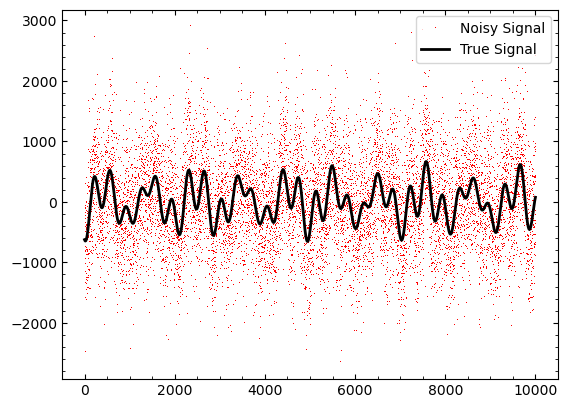

In [3]:
plt.plot(t, hn, 'r,', label='Noisy Signal')
plt.plot(t, h, 'k-', lw=2, label='True Signal')
plt.legend(numpoints=1)

Notice that signal is very noisy.  Without the true signal being drawn it would be very hard to guess what it looks like.

### Fourier Analysis

Performing a FFT is straightforward, we just us `np.fft.fft`.

In [ ]:
np.fft.fft?

So `fft` returns the (discrete) Fourier transform, but how is it organized?  The order in which the positive and negative frequencies are stored is given by `np.fft.fftfreq`.

In [ ]:
np.fft.fftfreq?

Notice that the zero frequency (DC level) is the first entry, then the positive ones, then the negative ones in reverse order.  For an odd number of samples the positive and negative frequencies are symmetric.  Here we calculate the FFT and look at the frequencies.

In [4]:
Hn = np.fft.fft(hn)
f = np.fft.fftfreq(N)
print(f)

[ 0.00000000e+00  9.99900010e-05  1.99980002e-04 ... -2.99970003e-04
 -1.99980002e-04 -9.99900010e-05]


The ordering is particularly convenient.  Notice that using array slicing we can easily pull out the positive and negative frequencies.

In [5]:
ind = np.arange(1, N//2+1) # We need integer division!
print(f[ind])
print(f[-ind])

[9.99900010e-05 1.99980002e-04 2.99970003e-04 ... 4.99750025e-01
 4.99850015e-01 4.99950005e-01]
[-9.99900010e-05 -1.99980002e-04 -2.99970003e-04 ... -4.99750025e-01
 -4.99850015e-01 -4.99950005e-01]


This is particularly useful for calculating the one sided power spectral density which combines the positive and negative frequencies. We can use this to identify which frequencies dominate the signal.
See the prelab for further discussion of the psd, here we will use a simplifed psd.

In [6]:
f[ind]

array([9.99900010e-05, 1.99980002e-04, 2.99970003e-04, ...,
       4.99750025e-01, 4.99850015e-01, 4.99950005e-01])

(0.0, 0.01)

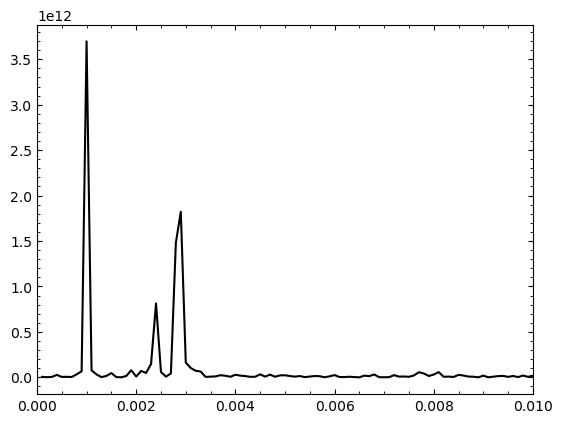

In [7]:
simple_psd = np.abs(Hn[ind])**2 + np.abs(Hn[-ind])**2
plt.plot(f[ind], simple_psd, 'k-')
# By construction we expect the frequencies to be small, so limit the plot
# to the low frequencies so we can see them.
plt.xlim(0, 0.01)

The dominant frequencies are those with the largest power spectral densities. What we mean by large is system dependent. For the data we have constructed we know there are only going to be a few frequencies. Looking at the figure we can pick an appropriate limit based on the peaks that are much larger than the rest.

In [8]:
print("Dominant frequencies:", f[ind[np.where(simple_psd>0.3e12)]]) # SET LIMIT BY HAND
print("True frequencies:    ", fs)

Dominant frequencies: [0.0009999  0.00239976 0.00279972 0.00289971]
True frequencies:     [0.00098659 0.00244479 0.00284837]


The dominant frequencies we find will not be exactly equal to the true ones. In fact, we may not even find the same number of frequencies, why not? Recall that the signal has been discretized.  This means a discrete set of frequencies are contained in the signal. Each value of the frequency in the digital signal actually corresponds to a range of frequencies in the analog signal. If two of the true frequencies are too close to each other they could appear as a single digital frequency. On the other hand, if the true frequency falls roughly halfway between two digital frequencies power will appear at both of them in the digitized signal.

### Gaussian Smoothing

Now that we have identified the frequencies, how do we extract the true signal from the noise? One way is to smooth the signal. We expect our signal to be dominated by low frequencies so we can reduce the power in high frequency modes by averaging the signal over some time scale.As a simple example, we could replace the signal by averaging the 11 time bins centered on each measured time. This would be "top hat" window function. It would remove information on scales smaller than 11 times the sampling rate. There are many other window functions that can be used.  A large selection of them are defined in `scipy.signal`.

What we are describing here is a convolution. Let $g(t)$ be our window function. As we saw in the lecture, the convolution is defined by
$$ h*g \equiv \int_{-\infty}^\infty h(\tau) g(t-\tau)\, \mathrm{d}\tau. $$
Though this can be calculated in the time domain (and there are functions that do this) it is typically much more efficient to calculate in the frequency domain. Let $H$ and $G$ be the Fourier transforms of $h$ and $g$, respectively. The convolution in the frequency domain is just the product of these Fourier transforms, $HG$, no integral required (of course they have just been replaced by the need to calculate FFT and an inverse FFT)! To calculate the convolution we can thus
1. Calculate the Fourier transforms of $h$ and $g$ which we call $H$ and $G$.
2. Calculate the product $HG$. (This is easy!)
3. Calculate the inverse Fourier transform of $HG$ to produce the convolution $h*g$.

This requires the calculate of a two Fourier transforms and an inverse transform. Even so, since the FFT is so fast this is typically much faster than performing the calculation in the time domain when the number of samples is larger than a few hundred.

As an example we will consider smoothing by a Gaussian,
$$ g(t) = \frac1{\sqrt{2\pi}\sigma} \exp\!\left( - \frac{t^2}{2\sigma^2} \right). $$

#### Convolution by Hand

We can directly calculate this convolution by following the above steps.  The width of the Gaussian determines the scale over which the smoothing occurs, a large $\sigma$ means a large smoothing scale.  Here we create a Gaussian with $\sigma=100$.

/home/copi/opt/anaconda/envs/p250/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/copi/opt/anaconda/envs/p250/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


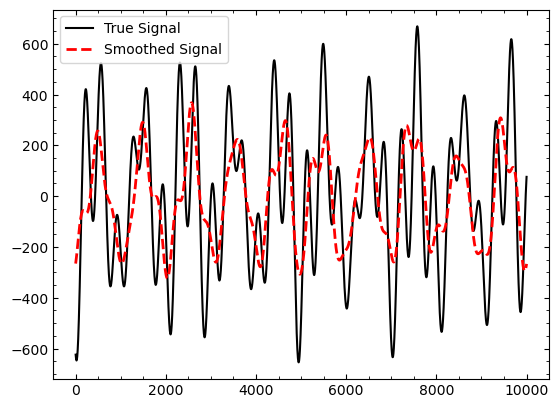

In [9]:
sigma = 100.
tt = np.arange(-N/2, N/2)
g = np.exp(-tt**2 / (2*sigma**2)) / np.sqrt(2*np.pi) / sigma
G = np.fft.fft(g)
conv1 = Hn * G
hg1 = np.fft.ifft(conv1)
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg1, 'r--', lw=2, label='Smoothed Signal')
plt.legend();

Notice that we got a warning. Recall the the Fourier transform is complex. Even though we have a real signal, the FFT gives us a complex valued result with the imaginary part zero (you should verify this). We could avoid the warning by only plotting the real part, i.e., using `hg1.real`. I will use this from now on.

The curve is nice and smooth so the noise has been removed, but **the smoothed signal does not look 
like the true signal**. What happened?

The problem is that a Fourier series assumes the signal is periodic. When we perform a convolution what happens when we try to include times outside the range of observations (off the left and right of the plot)? For the FFT it "wraps around" pulling information from the beginning of the signal when we are smoothing the values and the end and vice-versa at the beginning of the signal. How do we prevent this from happening? We use zero padding!

### Zero Padding

Zero padding is exactly as the name sounds, we increase the size of our array and fill it with zeros. Now when the FFT tries to go past the end of the true signal it hits zeros. This can be implemented in a few ways. We could do so directly by creating a larger array, putting the true signal in part of this array and zeros in the rest. Alternatively we can just let `fft` do the work for us. Again check the documentation and note the `n` keyword. This does precisely what we want.

Here we use zero padding by (effectively) doubling the size of the input arrays. Of course this also doubles the size of the final result, our smoothed signal, so where is the true signal? A quick plot shows us the answer.

**Note:** This is one use for zero padding.  Below it will be used to increase the resolution in frequency space.

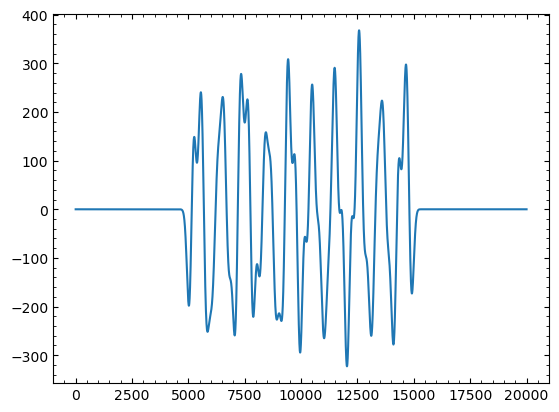

In [10]:
Hz = np.fft.fft(hn, n=2*N)
Gz = np.fft.fft(g, n=2*N)
conv2 = Hz * Gz
hg2 = np.fft.ifft(conv2)
plt.plot(hg2.real)

Notice that the smoothed signal appears in the middle of the array produced by the calculation. In practice where it appears depends on how we perform the zero padding. The approach we used for calculating the FFT put the zero padding after the true signal. Alternatively we could have put the padding before the true signal, center the true signal between zero padding, or split up the zeros however we like. These choices will just move the smoothed signal left and right in the result, but does not affect its shape. Here we pull out the smoothed signal and see that this does a much better job of reproducing the true one.

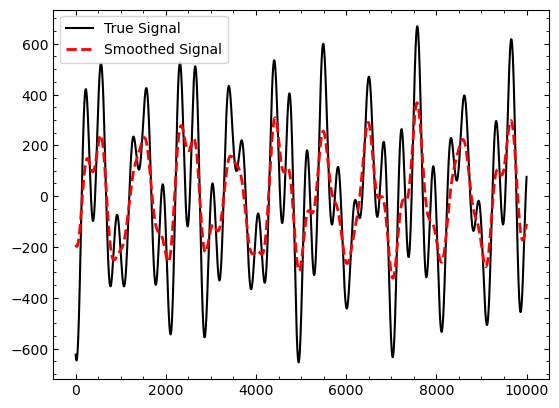

In [11]:
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg2[N//2:3*N//2].real, 'r--', lw=2, label='Smoothed Signal')
plt.legend();

### `scipy.signal.fftconvolve`

There are a number of functions that will calculate the convolution for us. Some do so in the time domain, some use the Fourier transform. Here only briefly mention one that figures out the best approach to use (time domain or FFT) for us. It can also include zero padding and much more so is much easier to use.

In [ ]:
signal.fftconvolve?

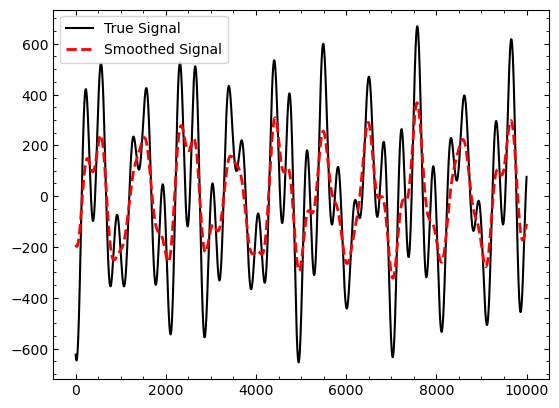

In [12]:
# Redo using scipy.signal.fftconvolve
hg3 = signal.fftconvolve(hn, g, mode='same')
plt.plot(t, h, 'k-', label='True Signal')
plt.plot(t, hg3.real, 'r--', lw=2, label='Smoothed Signal')
plt.legend();

Notice that the smoothed signal calculated by `signal.fftconvolve` looks exactly like the one we calculated by hand with zero padding.

## Diffraction

In optics the diffraction pattern in the far-field (Fraunhofer) limit is just a Fourier transform. For simplicity we will restrict ourselves to a one dimensional problem, though the same ideas apply in higher dimensions. Suppose light of wavelength $\lambda$ illuminates an aperture described by some function $A(x')$ where $x'$ measures the distance in the plane of the aperture. We can think of the aperture as a mask; it will be one where the light can pass through the aperture and zero where it cannot. The light passing through this aperture creates an image on a screen a distance $D$ from the aperture. Since light acts as a wave we do not get a sharp shadow of the aperture, but instead get an interference pattern due to the diffraction of the light. If we let $x$ represent the distance measured in the image plane on the screen then the *amplitude* of the signal is
$$ U(x) \propto \int_{-\infty}^\infty A(x') \exp\!\left(-\frac{2\pi\mathrm{i}x x'}{\lambda D} \right) \mathrm{d}x' \propto \tilde{A}(x). $$
Notice this is just the Fourier transform of the aperture function where we use $\tilde A(x)$ to represent the Fourier transform of $A(x')$ (this is the other common notation for the Fourier transform mentioned in the lecture). The intensity of the light is the square of the amplitude so the intensity pattern we would see is
$$ I(x) \propto \left| \int_{-\infty}^\infty A(x') \exp\!\left(-\frac{2\pi\mathrm{i}x x'}{\lambda D} \right) \mathrm{d}x' \right|^2 \propto \left| \tilde A(x) \right| ^2.  $$

### Single Slit

The first diffraction systems we study is a single, thin slit. Consider a slit of width $w$ illuminated by a monochromatic light source with wavelength $\lambda$. We wish to determine the diffraction pattern seen on a screen a distance $D$ from the aperture. Ignoring the proportionality constant (we can think of it as being absorbed into the units somewhere) the aperture function is
$$ A(x') = \begin{cases} 1, & |x'| \le w/2, \\ 0, & \mbox{otherwise} \end{cases}. $$
The amplitude of the pattern can be calculated analytically to find
$$ U(x) = \int_{-w/2}^{w/2} \exp\!\left(-\frac{2\pi\mathrm{i}x x'}{\lambda D} \right) \mathrm{d}x' \propto \left. \sin\!\left(\frac{\pi w x}{\lambda D}\right) \right/\! \left(\frac{\pi w x}{\lambda D} \right) \propto \operatorname{sinc}\!\left(\frac{w x}{\lambda D} \right). $$
**Warning:** This has been written in terms of the sinc function, however, there are multiple definitions in common usage. Two of the most common definitions are
$$ \operatorname{sinc}(x) = \frac{\sin x}{x} \quad \mbox{or} \quad \operatorname{sinc}(x) = \frac{\sin(\pi x)}{\pi x}. $$
Here we use the second definition (notice there is no $\pi$ in the argument of our sinc function) since this is the one used by `np.sinc`. *Always check the documentation of functions.* Conventions differ for many special functions. Always check the choice made in the library you are using.

### Signal Processing Analogy

This notation can be confusing since both $x$ and $x'$ measure distances but the domains in a Fourier transform should be inversely related to each other. For example, in signal processing the Fourier transform relates the time and frequency domains and the frequency has units of inverse seconds when the time has units of seconds. Notice that in the integral written above there are some other factors in the exponential and these are important for understanding the connection between the distance measured in the aperture plane, $x'$, and the distance measured in the image plane, $x$.

Despite using different symbols with very different physical meaning, this is still just a Fourier transform and we may calculate it just like we did when discussing signal processing. To make this connection more clear let us find an analogy between the time and frequency we use in signal processing and the positions $x$ and $x'$ we are using here. *Note:* We are **not** performing signal processing here so there is neither time nor frequency in the diffraction case, however, there are quantities that mathematically behave in the same way as these and we would like to identify them. This is often necessary since we use the Fourier transform to represent everything we can!

In the diffraction problem what quantity behaves like the frequency and what quantity behaves like the time? To answer this we compare the expression for $\tilde A(x)$ above to the way we wrote the Fourier transform in the signal processing case. Recall that we had written for a signal $h(t)$ the Fourier transform $H(f)$ is calculated as
$$ H(f) = \int_{-\infty}^{\infty} h(t) \mathrm{e}^{-2\pi \mathrm{i} f t} \,\mathrm{d} t.$$
From this we see that $t \rightarrow x'$, the integration variable, and in the exponential we thus have $ft = x x'/\lambda D$ so that $f \rightarrow x/\lambda D$.


### Discrete Fourier Transform

If we discretize the aperture plane in $N$ steps so that $x'_k = k w/N$ we will calculate the intensity pattern at a discrete set of locations, $x_n$, as
$$ I(x_n) = \left| \frac{w}{N} \sum_{k=-N/2}^{N/2-1} A(x'_k) \exp\left( \frac{2\pi\mathrm{i} kn}{N} \right) \right|^2 = \left| \tilde A(x_n) \right|^2. $$

We can write the discrete set of locations $x_n$ in terms of an integer $n$, the width $w$, and other constants, as appropriate. In the time/frequency case we know for a step size in the time domain, $\Delta$, then $f_n=n/N\Delta$. By analogy we are using $\Delta = w/N$ so using the result from the previous question $f_n = n/w = x_n/\lambda D$. Thus
$$ x_n = \frac{n\lambda D}{w}. $$

### Step Size

In an actual observation of a diffraction pattern there is a constraint on the size of the intensity pattern produced on the screen. The length of of this pattern will fix the step size we must use to discretize $z$ in the aperture plane. Recall from signal processing that the maximum frequency we can resolve is the Nyquist frequency. Turning this around we saw that this means if we want to resolve a maximum frequency there is a minimum sampling rate required in the time domain.

Suppose our screen is of length $L$ and we want our diffraction pattern to fit completely on the screen. Again using a width $w$ for the aperture plane this fixes the number of steps, $N$, we must use to sample the aperture plane.  We can calculate $N$ in terms of $w$, $L$, and other constants, as appropriate.

In signal processing we saw that for a time step of size $\Delta$ the Nyquist frequency is $f_c = 1/(2\Delta)$. We want $x_{\mathrm{max}}=L/2$ which will be related to the Nyquist frequency. Using our analogy from above we have $\Delta\rightarrow w/N$ so
$$ f_c \rightarrow \frac{x_{\mathrm{max}}}{\lambda D} = \frac{L}{2\lambda D} = \frac{N}{2w}. $$
Thus
$$ N = \frac{wL}{\lambda D}. $$

We can now calculate the diffraction pattern using a FFT.

As a specific example we will consider light of wavelength $\lambda=500\,\mathrm{nm}$ shining on an aperture plane of width $w=20\,\mu\mathrm{m}$ projecting an image onto a screen a distance $D=1\,\mathrm{m}$ from the aperture plane and creating a pattern of length $L=20\,\mathrm{cm}$. This is all defined below.

In [13]:
D = 1e2 # cm
lam = 500e-7 # cm
w = 20e-4 # cm
L = 20 # cm
# N must be an integer and, sadly, // is not sufficient for this!
N = int(w * L / (D * lam))
print("Number of samples =", N)

Number of samples = 8


Define aperture function for the slit.

In [14]:
def aperture(xp, w) :
    """Aperture for a single slit of width w centered at xp=0.
    Inputs:
      xp: array: positions in the aperture plane
      w: float: full width of the slit
    Outputs:
      A: array (same shape as xp): Values of the aperture mask
         1 = fully transparent, 0 = fully opaque.
    xp and w must be in the same units.
    """
    A = np.ones_like(xp)
    A[np.abs(xp) > w/2] = 0
    return A

### Intensity Pattern

We are now ready to calculate the intensity pattern using the FFT. To do this we calculate the Fourier transform of the aperture function, $A(x')$. This function must be evaluated at a discrete set of points, $x'_n$, chosen in a coordinate system in the aperture plane such that $-w/2\le x'\le w/2$. Previously we found that it must be discretized in $N$ steps so that the resulting intensity pattern will fit on our screen. Finally, for the Fourier transform we require the points to be equally spaced. With this we use the FFT to transform the aperture function and from this calculate the intensity.

#### Full FFT

We can proceed as we did above and use the full FFT. As we saw, this includes positive and negative frequencies.

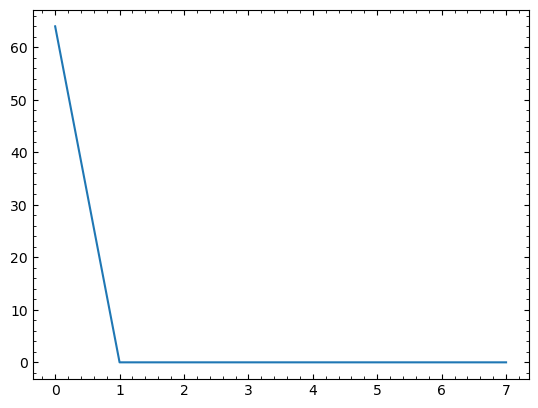

In [15]:
Delta = w / N
xpn = np.arange(-w/2, w/2, Delta)
A = aperture(xpn, w)
ckFFT = np.fft.fft(A)
IFFT = np.abs(ckFFT)**2
plt.plot(IFFT)

Here we have plotted the intensity pattern as a function of index number. We see that the result is mostly symmetric around the center of the plot with the only difference being in the zero frequency (first point).

This is nice, but we expect the intensity pattern to have peaks centered around zero, that is not what we see in our quick plot! As discussed above, the FFT provides the results in a particular order convenient for some calculations, but not for looking at the result as we are doing here. Also discussed was the use of `fftshift` to reorganize the result of the FFT and the use of `fftfreq` for calculating the "frequencies". We can use both of these functions to improve our plot of the intensity pattern.

Finally, we would like to compare this to the expected intensity pattern. For this comparison we need to deal with the normalization, i.e., they both need to be normalized in the same way. For the expected pattern we have normalized it so that its maximum at $I(0)=1$. How do we do the same for the FFT version? Once again *it depends*.

#### Renormalizing the FFT

As always this detail depends on the FFT library used. The documentation for `np.fft.fft`, in particular the examples, show that to normalize the FFT we need to divide by the number of samples, N. This step is only necessary if we are interested in the values returned by `np.fft.fft`. We should not renormalize the results if we are just going to transform form the back to the time domain.

Note: Actually, `np.fft` allows you to choose the normalization. The norm keyword can be used to switch to a symmetric normalization. See the documentation of `np.fft` for more details. We will not use this feature.

Thus, we can normalize the result from the FFT and the expected and calculated intensities should agree.

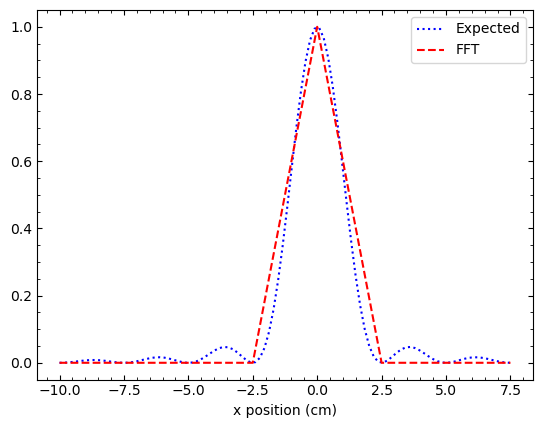

In [16]:
# We could shift the returned value from fft and recalculate the intensity,
# or more simply just shift the intensity directly.
ckshifted = np.fft.fftshift(ckFFT)
# Include the 1/N normalization here.
IFFT = np.abs(ckshifted / N)**2
x = L / N * np.arange(-N/2, N/2) # cm
# Expected result
xfine = np.linspace(x[0], x[-1], 100)
plt.plot(xfine, np.sinc(w * xfine / (lam * D))**2, 'b:', label='Expected')
plt.plot(x, IFFT, 'r--', label='FFT')
plt.legend()
plt.xlabel('x position (cm)');

#### Real FFT

Before addressing this result, let us consider an alternative approach. Since the signal is real we are storing more information than we need. For a real signal the Fourier amplitudes with negative frequency are the complex conjugate of the positive frequency amplitudes.

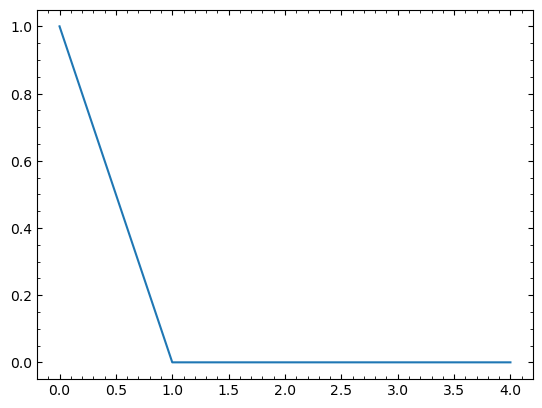

In [17]:
ckrFFT = np.fft.rfft(A)
IrFFT = np.abs(ckrFFT / N)**2
plt.plot(IrFFT)

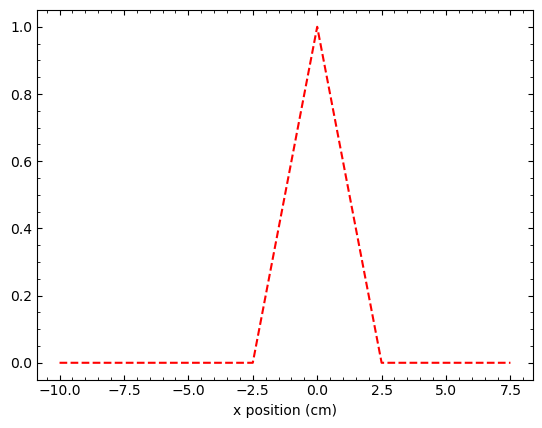

In [18]:
# We need to "wrap" the result to negative frequencies, i.e., negative distances.
Ifull = np.zeros(N)
# We want to put things in the same order as np.fft.fftshift does.
# We do it by hand and it is tedious.
Ifull[:N//2+1] = IrFFT[::-1]
Ifull[N//2+1:] = IrFFT[1:-1]
x = L / N * np.arange(-N/2, N/2) # cm
plt.plot(x, Ifull, 'r--')
plt.xlabel('x position (cm)');

In [19]:
print("FFT == rFFT?", np.allclose(IFFT, Ifull))

FFT == rFFT? True


### High Resolution Intensity Pattern

Now that we have a plot we can easily read we see that the intensity pattern is *not* well sampled. In other words, the $N$ we used for discretizing the aperture function is rather small. This $N$ also corresponds to the number of points at which the intensity pattern is calculated. We would prefer to calculate the intensity pattern at a much higher resolution. 

Our first thought is probably to just sample the aperture function more finely. However, this does not improve the resolution.

We *can* improve the resolution by increasing the width of the aperture. Physically it is simple to increase the width of the aperture by adding more opaque portions to it. Since the opaque portions do not transmit light the resulting diffraction pattern will not change. Computationally this is nothing more than zero padding! Notice that zero padding **does not sample the aperture plane more finely**, it instead makes the array we transform longer. In fact, we do not need to change the discrete array calculated for the aperture at all. Despite the fact that we still sample the aperture plane with the same steps in $x'$, the intensity pattern will be calculated at higher resolution when we zero pad. Here we use the same approach as discussed above.

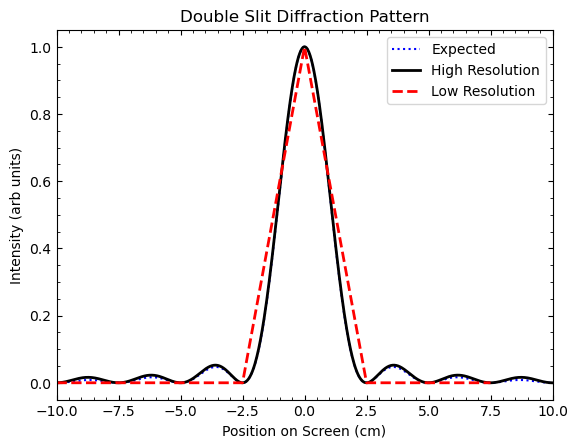

In [20]:
Nhires = 100 * N
ckhires = np.fft.rfft(A, n=Nhires)
Itmp = np.abs(ckhires / N)**2
Ihires = np.zeros(Nhires)
Ihires[:Nhires//2+1] = Itmp[::-1]
Ihires[Nhires//2+1:] = Itmp[1:-1]

fig = plt.figure()
ax = fig.add_subplot(111)
xhires = L / Nhires * np.arange(-Nhires/2, Nhires/2) # cm
ax.plot(xhires, np.sinc(w * xhires / (lam * D))**2, 'b:', label="Expected")
ax.plot(xhires, Ihires, 'k-', lw=2, label="High Resolution")
ax.plot(x, Ifull, 'r--', lw=2, label='Low Resolution')
ax.set_xlim(-L/2, L/2)
ax.set_xlabel('Position on Screen (cm)')
ax.set_ylabel('Intensity (arb units)')
ax.set_title('Double Slit Diffraction Pattern')
ax.legend();

### Images

The figure above is good, but what would we actually see if we did this experiment? In principle would could set this up in a dark room and look at the image that is produced on the screen. From our calculations we can use `imshow` to produce an image that should look like the pattern we would find in such an experiment. Here we will run into some issues with its usage.

Let `I` represent the intensity pattern we calculated above. Here are some of the issues we encounter.
1. **One dimensional array:**  If we try to directly use `I` with `imshow` we get an error about invalid dimensions.(You should try this and all the other other steps given here to see the original behavior and how we correct it.) This happens because `imshow` expects a two dimensional array, but we passed it a one dimensional array. We can fix this by treating our array as a two dimensional one, that is as a $1\times N$ array. This can easily be accomplished by using `[I,]` instead of just `I`.
2. **Short image:** The previous step allows `imshow` to run but now it produces a very short image, in fact, only one pixel tall. This is not very easy to read. We would like to stretch the image along the $y$-axis. Physically the aperture plane is two dimensional but we have only performed a one dimensional calculation. The actual intensity pattern will be stretched along the $y$-axis due to the fact that slits extend (a large distance compared to their width) in this direction. We can achieve this stretching in a number of ways. With `imshow` we could use the `aspect` or `extent` keywords for this purpose. We will use the `extent` keyword as this will allow us to give meaning to the $x$-axis. When you look up the documentation for `imshow` you will see that `extent` is provided as a list of four values representing the $x$ and $y$ ranges of the image. We know the $x$ range, that is determined by the coordinate system of the screen on which the intensity pattern appears.  We are using centimeters for our units along this axis so we will use these units for the $y$ axis too. An aspect ratio of approximately 5 times wider than it is tall looks reasonable though you can play with other aspect ratios.
3. **Color map:** Now we can use `imshow` to make a nice image with a good aspect ratio. When we do so it produces a pretty color image using the default color map. Though this looks good and makes it easier to see the dim side peaks, the colors are misleading. We are trying to produce an image that would look exactly like what we would observe in an experiment. Our calculation is for a *monochromatic light source* so we would not see a rainbow of colors in the intensity pattern! It is more appropriate to use a gray scale color map. Not surprisingly such a color map exists, it is called `gray`, and can be used with `imshow`. 
4. **Axis ticks/labels:** The $x$-axis in this image means something and they $y$-axis does not. It makes sense to remove the tick marks and labels on the $y$-axis and change them on the $x$-axis to denote the physical distance in the plane of the screen. This can be accomplished using `ax.set_yticks` and `ax.set_xticks`, respectively. To remove the ticks we can just pass in an empty list. To set the ticks to specify values we can pass in an array with the numeric value of where we want the tick to occur. For this image it makes sense to put a tick mark every centimeter along the $x$-axis. If the `extent` keyword was used with `imshow` as suggested above this is straightforward.

Putting all of this together we end up with the following images.

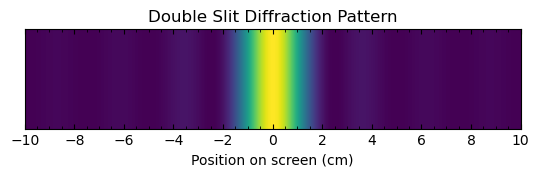

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
dg = ax.imshow([Ihires,], extent=[xhires[0], xhires[-1], 0, 4])
ax.set_yticks([])
ax.set_xticks(np.arange(-L/2, L/2+0.1, 2))
ax.set_xlabel('Position on screen (cm)')
ax.set_title('Double Slit Diffraction Pattern');

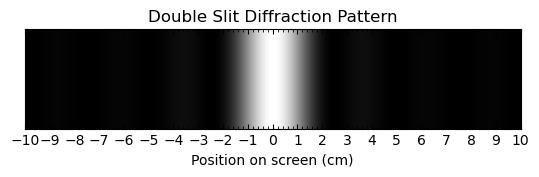

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
dg = ax.imshow([Ihires,], extent=[xhires[0], xhires[-1], 0, 4], cmap='gray')
ax.set_yticks([])
ax.set_xticks(np.arange(-L/2, L/2+0.1, 1))
ax.set_xlabel('Position on screen (cm)')
ax.set_title('Double Slit Diffraction Pattern');